In [3]:
# %pip install --upgrade jax[cuda12]

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 15.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 25.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 18.3 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 552.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# %pip install jaxopt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.7 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import jax.numpy as jnp
from jax.numpy import trapezoid
from jax import grad, jit, vmap, value_and_grad, hessian
from jax.numpy.fft import fft, fftfreq, fftshift, ifft
from jax import random, config, jit
from jax.nn import sigmoid
from jaxopt import LBFGS, BFGS, ArmijoSGD
from jax.lax import Precision, stop_gradient
from jax.flatten_util import ravel_pytree
from collections import namedtuple
import math

config.update("jax_enable_x64", True)

In [138]:
seed = random.key(1)

In [139]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1.):
  w_key, b_key = random.split(key)
  #return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
  return scale * random.uniform(w_key, (n, m), minval = - 1/jnp.sqrt(n*m), maxval =  1/jnp.sqrt(n*m)), scale * random.uniform(b_key, (n,), minval = - 1/jnp.sqrt(n), maxval =  1/jnp.sqrt(n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  p = [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
  return p

In [140]:
layer_sizes = [1, 14, 14, 14, 7, 7, 7, 7, 1]
#layer_sizes = [1, 64, 1]

step_size = 0.001
r_func_norm = 0.2

num_epochs = 1001
batch_size = 2000
params_1 = init_network_params(layer_sizes, seed)
params_2 = init_network_params(layer_sizes, seed)

L = 8.

# points_half = jnp.geomspace(1, L+1, batch_size//2 + 1) - 1
# points = jnp.concatenate((-points_half[1:][::-1], points_half))
# points = jnp.expand_dims(points, axis = 1)

points = jnp.expand_dims(jnp.linspace(0.,2*L, num = batch_size+1), axis = 1)
# p_a = jnp.array([[-L]])
# p_b = jnp.array([[L]])
# points = random.uniform(seed, (batch_size-1, 1), minval = -L, maxval = L)

# points = jnp.vstack((p_a, points, p_b))

n_factor = 2*L #jnp.std(points)
points = points/n_factor

# points_s = jnp.sort(points, axis=0)

xb = 2*L/n_factor

In [141]:
jnp.all(ravel_pytree(params_1)[0] == ravel_pytree(params_2)[0])

Array(True, dtype=bool)

In [142]:
len(params_1)

8

In [143]:
ravel_pytree(params_1)[0].shape

(729,)

In [144]:
def tanh(x):
    return 1*jnp.tanh(x)

def alpha_R(x):
    return -0.9*jnp.exp(-((x-xb/2)/xb*10)**2)
    #return 0.5-x**2/xb**2/2
    #return 0.5*jnp.cos(x/(0.2))
    #return 0.

def R_func_0(x):
    func = (xb - jnp.sqrt(x**2 + (xb-x)**2 - 2*x*(xb-x)*alpha_R(x)))/(1+alpha_R(x))

    #dfunc_dx = -2*x/jnp.sqrt((x+xb)**2 + (x-xb)**2)

    return func.squeeze() #, dfunc_dx

R_func_val_grad = value_and_grad(R_func_0)

def R_func(x):
    func, dfunc_dx = R_func_val_grad(x)
    #max_fun = stop_gradient(2*jnp.max(func))

    return func/r_func_norm, dfunc_dx/r_func_norm

v_R_func = vmap(R_func)

def boundary_func(x):
    # func = jnp.pi/2*(x/xb + 1)
    # dfunc_dx = jnp.pi/2/xb

    func = jnp.pi*sigmoid(x*n_factor-L)
    dfunc_dx = n_factor*jnp.pi*sigmoid(x*n_factor-L)*(1-sigmoid(x*n_factor-L))

    return func, dfunc_dx

def forward(params, x):
    # per-example predictions
    r_func, dr_func_dx = R_func(x)
    b_func, db_func_dx = boundary_func(x)
    activations = x

    # for w, b in params:

    #   outputs = jnp.dot(w, activations) + b
    #   activations = tanh(outputs)

    ############################################################################
    w0, b0 = params[0]

    outputs = jnp.dot(w0, activations) + b0
    activations_in = tanh(outputs)

    w1, b1 = params[1]

    outputs = jnp.dot(w1, activations_in) + b1
    activations = tanh(outputs)

    w2, b2 = params[2]

    outputs = jnp.dot(w2, activations) + b2

    outputs = outputs + activations_in
    activations_out = tanh(outputs)

    w3, b3 = params[3]

    outputs = jnp.dot(w3, activations_out) + b3

    activations = tanh(outputs)

    w4, b4 = params[4]

    outputs = jnp.dot(w4, activations) + b4

    activations_in = tanh(outputs)

    w5, b5 = params[5]

    outputs = jnp.dot(w5, activations) + b5

    activations = tanh(outputs)

    w6, b6 = params[6]

    outputs = jnp.dot(w6, activations) + b6
    outputs = outputs + activations_in

    activations_out = tanh(outputs)

    w7, b7 = params[7]

    outputs = jnp.dot(w7, activations_out) + b7

    activations = tanh(outputs)
    ############################################################################

    # res = b_func - r_func*dr_func_dx*db_func_dx + r_func**2*activations
    res = b_func + r_func**2*activations
    return jnp.squeeze(res)

def forward_f(params, x):
    return jnp.squeeze(forward(params, x))

deep_ritz = value_and_grad(forward, argnums=1)
v_deep_ritz = vmap(deep_ritz, in_axes = (None, 0))

def pinn_forward(params, x):

    d2u_dx2 = hessian(forward, argnums=1)(params, x)

    u = forward(params, x)

    return u, d2u_dx2

v_pinn = vmap(pinn_forward, in_axes = (None, 0))

v_out_value = vmap(forward, in_axes = (None, 0))

In [145]:
out, dout_dx = v_deep_ritz(params_1, points)
print(out.shape)
print(dout_dx.shape)

(2001,)
(2001, 1)


In [146]:
out, d2out_dx2 = v_pinn(params_2, points)
print(out.shape)
print(d2out_dx2.shape)

(2001,)
(2001, 1, 1)


In [147]:
res = v_out_value(params_1, points)

In [148]:
res.shape

(2001,)

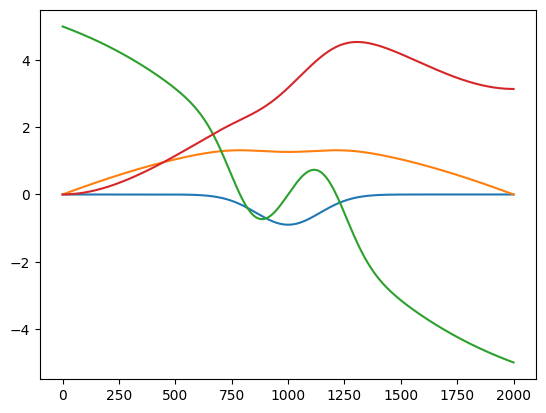

In [149]:
import matplotlib.pyplot as plt

alpha_func = alpha_R(points)
r_func, dr_func_dx = v_R_func(points)
b_func, db_func_dx = boundary_func(points)

plt.plot(alpha_func)
plt.plot(r_func)
plt.plot(dr_func_dx)
plt.plot(b_func.squeeze() + r_func.squeeze()**2)

In [150]:
jnp.min(r_func)

Array(0., dtype=float64)

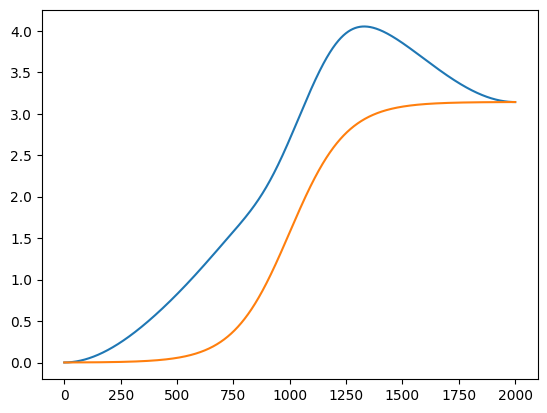

In [151]:
import matplotlib.pyplot as plt
plt.plot(out)
plt.plot(b_func)

In [152]:
@jit
def loss_deep_ritz(params, points):
  out, dout_dx = v_deep_ritz(params, points)

  return jnp.trapezoid(dout_dx.squeeze()**2/n_factor**2 + jnp.sin(out.squeeze())**2, x = points, axis = 0).squeeze()

@jit
def loss_pinn(params, points):
  u, d2u_dx2 = v_pinn(params, points)

  return jnp.sum((d2u_dx2.squeeze()/n_factor**2 - jnp.sin(u.squeeze())*jnp.cos(u.squeeze()))**2, axis = 0).squeeze()/(batch_size+1)

@jit
def l2_accuracy(sol, sol_true, points):
    res = jnp.sqrt(jnp.trapezoid((jnp.squeeze(sol) - jnp.squeeze(sol_true))**2, x = points, axis = 0)/(2*xb))
    return jnp.squeeze(res)

@jit
def conv_accuracy(sol, sol_true):
    sol_spec = fft(jnp.squeeze(sol))
    sol_true_spec = fft(jnp.squeeze(sol_true))

    spec_mul = sol_spec*sol_true_spec

    conv = ifft(spec_mul)
    return jnp.argmax(jnp.real(conv))

@jit
def zero_position(sol):
    y = (sol.squeeze()-jnp.pi/2)**2
    return jnp.argmin(y)

In [153]:
loss_deep_ritz(params_1, points)

Array(0.49065756, dtype=float64)

In [154]:
loss_pinn(params_2, points)

Array(0.21948758, dtype=float64)

In [155]:
import time

# optimizer = BFGS(
#     loss,
#     stepsize = 0.003,
#     linesearch="zoom",
#     verbose = False,
#     max_stepsize=1.0,
#     linesearch_init = "max",
#     maxls = 50,
#     tol=1e-6,
#     jit = True)

#optimizer = ArmijoSGD(loss, max_stepsize=0.1, momentum=0.9)

#optimizer = LBFGS(loss, stepsize = 0.006, history_size = 200)

optimizer_1 = LBFGS(loss_deep_ritz, linesearch = "hager-zhang", max_stepsize=1.0, linesearch_init='max', verbose=False, jit = True)
optimizer_2 = LBFGS(loss_pinn, linesearch = "hager-zhang", max_stepsize=1.0, linesearch_init='max', verbose=False, jit = True)

state_1 = optimizer_1.init_state(params_1, points)
state_2 = optimizer_2.init_state(params_2, points)

loss_array_1 = jnp.empty(num_epochs)
loss_array_2 = jnp.empty(num_epochs)

acc_array_1 = jnp.empty(num_epochs)
acc_array_2 = jnp.empty(num_epochs)

conv_array_1 = jnp.empty(num_epochs)
conv_array_2 = jnp.empty(num_epochs)

step_array_1 = jnp.empty(num_epochs)
step_array_2 = jnp.empty(num_epochs)

zero_pos_1 = jnp.empty(num_epochs)
zero_pos_2 = jnp.empty(num_epochs)

sol_true = 2*jnp.atan(jnp.exp(points*n_factor-L))
# sol_spec = jnp.abs(fftshift(fft(jnp.squeeze(sol_true))))

acc_check_1 = 100
acc_check_2 = 100

for epoch in range(num_epochs):
  start_time = time.time()

  loss_train_1 = loss_deep_ritz(params_1, points)
  loss_train_2 = loss_pinn(params_2, points)

  params_1, state_1 = optimizer_1.update(params_1, state_1, points)
  params_2, state_2 = optimizer_2.update(params_2, state_2, points)

  out_1 = v_out_value(params_1, points)
  out_2 = v_out_value(params_2, points)

  # out_1_spec = jnp.abs(fftshift(fft(jnp.squeeze(out_1))))
  # out_2_spec = jnp.abs(fftshift(fft(jnp.squeeze(out_2))))

  zero_pos_current_1 = zero_position(out_1)
  zero_pos_current_2 = zero_position(out_2)

  zero_pos_1 = zero_pos_1.at[epoch].set(zero_pos_current_1)
  zero_pos_2 = zero_pos_2.at[epoch].set(zero_pos_current_2)

  loss_array_1 = loss_array_1.at[epoch].set(loss_train_1)
  loss_array_2 = loss_array_2.at[epoch].set(loss_train_2)

  acc_current_1 = l2_accuracy(out_1, sol_true, points)
  acc_current_2 = l2_accuracy(out_2, sol_true, points)

  # conv_1 = conv_accuracy(out_1, sol_true)
  # conv_2 = conv_accuracy(out_2, sol_true)

  if acc_current_1 < acc_check_1:
      best_p_1 = params_1
      acc_check_1 = acc_current_1

  if acc_current_2 < acc_check_2:
      best_p_2 = params_2
      acc_check_2 = acc_current_2

  acc_array_1 = acc_array_1.at[epoch].set(acc_current_1)
  acc_array_2 = acc_array_2.at[epoch].set(acc_current_2)

  # conv_array_1 = conv_array_1.at[epoch].set(conv_1)
  # conv_array_2 = conv_array_1.at[epoch].set(conv_2)

  step_array_1 = step_array_1.at[epoch].set(state_1.stepsize)
  step_array_2 = step_array_2.at[epoch].set(state_2.stepsize)

  epoch_time = time.time() - start_time

  if (epoch)%10 == 0:
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set Deep Ritz loss {}".format(loss_train_1))
    print("Deep acc", acc_current_1)
    print("Training set PINN loss {}".format(loss_train_2))
    print("PINN acc", acc_current_2, "\n")

Epoch 0 in 94.58 sec
Training set Deep Ritz loss 0.49065756196803106
Deep acc 0.191044388885456
Training set PINN loss 0.21948758239983104
PINN acc 0.07461989725921363 

Epoch 10 in 0.25 sec
Training set Deep Ritz loss 0.25507672674231197
Deep acc 0.04260276091009687
Training set PINN loss 0.006574519909103258
PINN acc 0.04189029645025501 

Epoch 20 in 0.25 sec
Training set Deep Ritz loss 0.25419649594515625
Deep acc 0.0367270757013972
Training set PINN loss 0.0065665126962425645
PINN acc 0.041597818441780225 

Epoch 30 in 0.24 sec
Training set Deep Ritz loss 0.2540941562807688
Deep acc 0.03605473774180904
Training set PINN loss 0.006560218293752533
PINN acc 0.04115411684637495 

Epoch 40 in 0.24 sec
Training set Deep Ritz loss 0.2531380895623542
Deep acc 0.027617762126808755
Training set PINN loss 0.006340814797997715
PINN acc 0.03817319346335971 

Epoch 50 in 0.24 sec
Training set Deep Ritz loss 0.2523922853947643
Deep acc 0.022692288362286168
Training set PINN loss 0.005904670184735

In [156]:
out_1 = v_out_value(params_1, points)
out_2 = v_out_value(params_2, points)

best_out_1 = v_out_value(best_p_1, points)
best_out_2 = v_out_value(best_p_2, points)

print(out_1.shape)

(2001,)


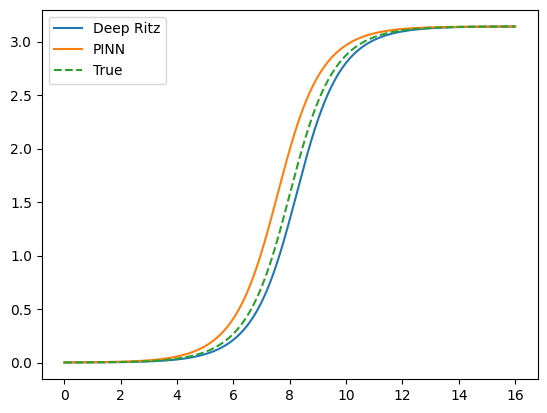

In [157]:
import matplotlib.pyplot as plt
plt.plot(points*n_factor, out_1, label = "Deep Ritz")
plt.plot(points*n_factor, out_2, label = "PINN")
plt.plot(points*n_factor, sol_true, "--", label = "True")
plt.legend()
plt.show()

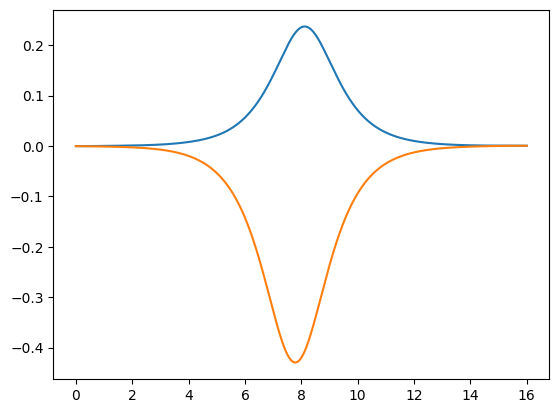

In [158]:
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(out_1))
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(out_2))

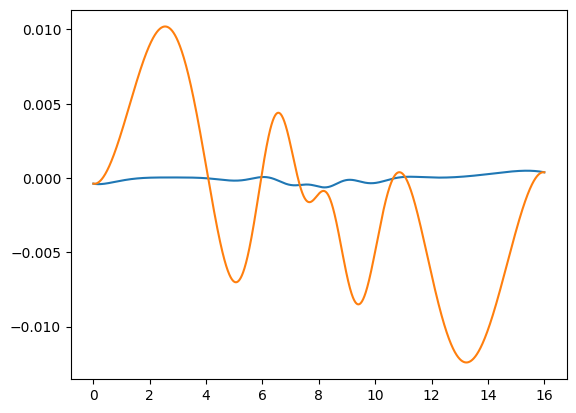

In [159]:
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(best_out_1))
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(best_out_2))

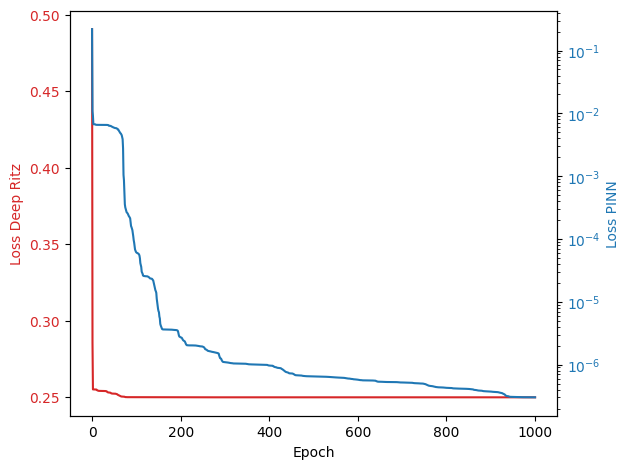

In [160]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Deep Ritz', color=color)
ax1.plot(loss_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss PINN', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(loss_array_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

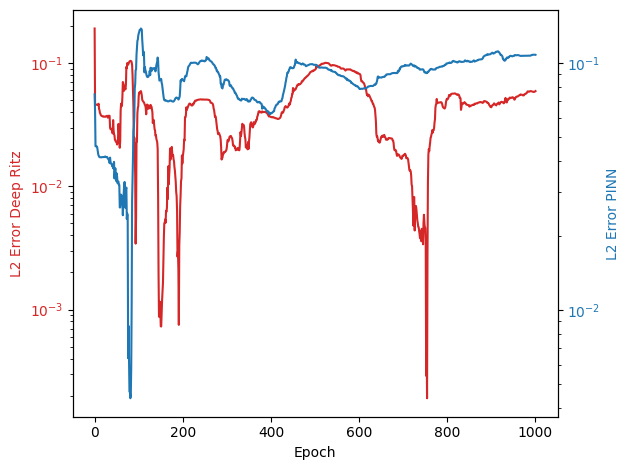

In [161]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Error Deep Ritz', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('L2 Error PINN', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(acc_array_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [162]:
print("min acc Deep Ritz", jnp.min(acc_array_1))
print("min acc PINN", jnp.min(acc_array_2))

min acc Deep Ritz 0.00019043706952655997
min acc PINN 0.004385827108948008


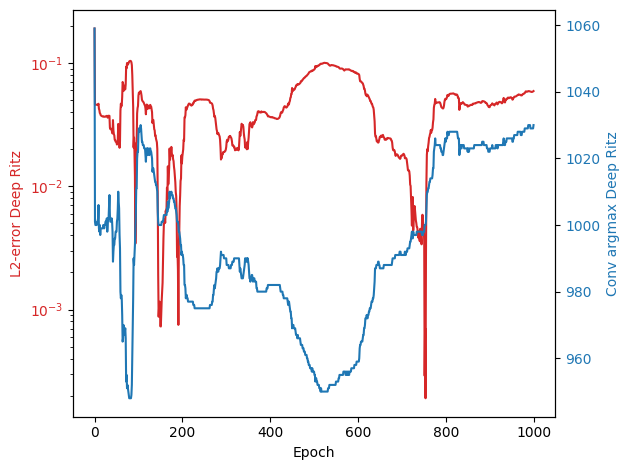

In [163]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2-error Deep Ritz', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Conv argmax Deep Ritz', color=color)  # we already handled the x-label with ax1
ax2.plot(zero_pos_1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

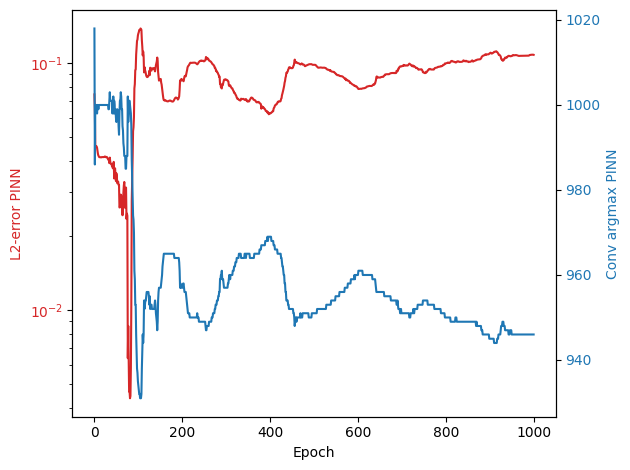

In [164]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2-error PINN', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Conv argmax PINN', color=color)  # we already handled the x-label with ax1
ax2.plot(zero_pos_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

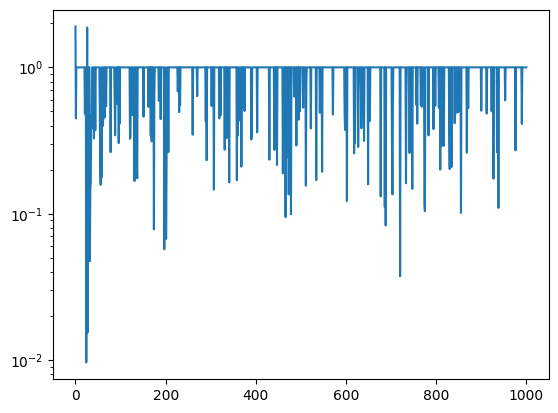

In [165]:
plt.plot(step_array_1)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [166]:
jnp.mean(step_array_1)

Array(0.90362347, dtype=float64)

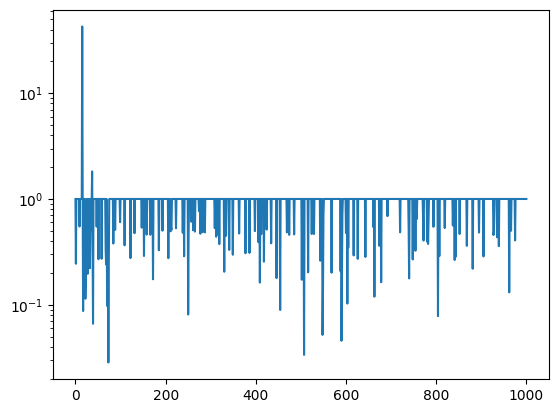

In [167]:
plt.plot(step_array_2)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [168]:
jnp.mean(step_array_2)

Array(0.95960192, dtype=float64)